# Top Rule Deep Analysis (Extended)
## 最高品質ルールの包括的分析（時間変数T考慮版）

このノートブックでは、最も品質の高いルールに対して時間変数Tを考慮した包括的な分析を行います。

In [11]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, t as t_dist
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# スタイル設定
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 10)

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [12]:
# データの読み込み
path = '../output/IB'
all_files = glob.glob(os.path.join(path, "*.txt"))

print(f"Loading {len(all_files)} files...")
all_dfs = []
for i, filename in enumerate(all_files):
    df = pd.read_csv(filename, sep='\t')
    # ファイル番号を追加（時間的な順序として扱う可能性）
    df['file_index'] = i
    df['file_name'] = os.path.basename(filename)
    all_dfs.append(df)

combined_df = pd.concat(all_dfs, ignore_index=True)
combined_df['Chi_squared'] = combined_df['Chi_squared'].fillna(0)

print(f"\nTotal rules loaded: {len(combined_df):,}")
print(f"\nAvailable columns: {list(combined_df.columns)}")
print(f"\nData shape: {combined_df.shape}")


Loading 100 files...

Total rules loaded: 200,000

Available columns: ['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8', 'Actual_X_mean', 'Actual_X_sigma', 'X_mean', 'X_sigma', 'support_count', 'support_rate', 'HighSup', 'LowVar', 'Chi_squared', 'HighChi', 'NumAttr', 'DomMonth', 'DomQuarter', 'DomDay', 'TimeSpan', 'file_index', 'file_name']

Data shape: (200000, 25)


In [13]:
# トップルールを特定
filtered_df = combined_df[
    (combined_df['support_rate'] >= 0.1) &
    ((combined_df['Chi_squared'] >= 3.84) | (combined_df['Chi_squared'] == 0))
].copy()

filtered_df['chi_bonus'] = 1 + filtered_df['Chi_squared'] / 10
filtered_df['score'] = (
    filtered_df['support_rate'] *
    filtered_df['support_count'] *
    filtered_df['chi_bonus']
)

filtered_df = filtered_df.sort_values(by='score', ascending=False)
filtered_df_unique = filtered_df.drop_duplicates(subset=['Attr1', 'Attr2', 'Attr3'], keep='first')

# トップルール
top_rule = filtered_df_unique.iloc[0]

print("="*80)
print("TOP RULE IDENTIFICATION")
print("="*80)
print(f"Rule: {top_rule['Attr1']} & {top_rule['Attr2']} & {top_rule['Attr3']}")
print(f"Score: {top_rule['score']:.2f}")
print(f"Support Rate: {top_rule['support_rate']:.4f}")
print(f"Chi-squared: {top_rule['Chi_squared']:.3f}")
print(f"Mean Return: {top_rule['Actual_X_mean']:.4f}")
print("="*80)

TOP RULE IDENTIFICATION
Rule: 9434_Stay(t-1) & 6178_Stay(t-1) & 0
Score: 5949.90
Support Rate: 0.8435
Chi-squared: 5.887
Mean Return: 0.0440


In [14]:
# トップルールの全バリエーションを抽出（時間軸での分析用）
top_rule_variations = combined_df[
    (combined_df['Attr1'] == top_rule['Attr1']) &
    (combined_df['Attr2'] == top_rule['Attr2'])
].copy()

# 時間変数Tの推定（TimeSpanまたはfile_indexを使用）
if 'TimeSpan' in top_rule_variations.columns:
    # TimeSpanをソートして時間軸Tとする
    top_rule_variations = top_rule_variations.sort_values('TimeSpan')
    top_rule_variations['T'] = range(len(top_rule_variations))
    print(f"\nUsing TimeSpan as temporal reference")
else:
    top_rule_variations['T'] = top_rule_variations['file_index']
    print(f"\nUsing file_index as temporal reference")

print(f"\nFound {len(top_rule_variations)} variations of the top rule")
print(f"Time span: T=0 to T={len(top_rule_variations)-1}")

# スコアを計算（top_rule_variationsはcombined_dfから来ているのでscoreがない）
top_rule_variations['chi_bonus'] = 1 + top_rule_variations['Chi_squared'] / 10
top_rule_variations['score'] = (
    top_rule_variations['support_rate'] *
    top_rule_variations['support_count'] *
    top_rule_variations['chi_bonus']
)

# 追加の派生指標を計算
top_rule_variations['sharpe_ratio'] = top_rule_variations['Actual_X_mean'] / (top_rule_variations['Actual_X_sigma'] + 1e-6)
top_rule_variations['info_ratio'] = (top_rule_variations['Actual_X_mean'] - top_rule_variations['X_mean']) / (top_rule_variations['Actual_X_sigma'] + 1e-6)
top_rule_variations['excess_return'] = top_rule_variations['Actual_X_mean'] - top_rule_variations['X_mean']
top_rule_variations['volatility_ratio'] = top_rule_variations['Actual_X_sigma'] / (top_rule_variations['X_sigma'] + 1e-6)
top_rule_variations['risk_adjusted_score'] = top_rule_variations['score'] / (top_rule_variations['Actual_X_sigma'] + 1e-6)

print(f"\nDerived metrics calculated:")
print(f"  - Sharpe Ratio: {top_rule_variations['sharpe_ratio'].mean():.4f}")
print(f"  - Information Ratio: {top_rule_variations['info_ratio'].mean():.4f}")
print(f"  - Excess Return: {top_rule_variations['excess_return'].mean():.4f}")
print(f"  - Volatility Ratio: {top_rule_variations['volatility_ratio'].mean():.4f}")



Using TimeSpan as temporal reference

Found 19 variations of the top rule
Time span: T=0 to T=18

Derived metrics calculated:
  - Sharpe Ratio: 0.0259
  - Information Ratio: 0.0269
  - Excess Return: 0.0465
  - Volatility Ratio: 0.9718


In [18]:
# トップルールの全バリエーションを抽出（時間軸での分析用）
top_rule_variations = combined_df[
    (combined_df['Attr1'] == top_rule['Attr1']) &
    (combined_df['Attr2'] == top_rule['Attr2'])
].copy()

# 時間変数Tの推定（TimeSpanまたはfile_indexを使用）
if 'TimeSpan' in top_rule_variations.columns:
    # TimeSpanをソートして時間軸Tとする
    top_rule_variations = top_rule_variations.sort_values('TimeSpan')
    top_rule_variations['T'] = range(len(top_rule_variations))
    print(f"\nUsing TimeSpan as temporal reference")
else:
    top_rule_variations['T'] = top_rule_variations['file_index']
    print(f"\nUsing file_index as temporal reference")

print(f"\nFound {len(top_rule_variations)} variations of the top rule")
print(f"Time span: T=0 to T={len(top_rule_variations)-1}")

# 追加の派生指標を計算
top_rule_variations['sharpe_ratio'] = top_rule_variations['Actual_X_mean'] / (top_rule_variations['Actual_X_sigma'] + 1e-6)
top_rule_variations['info_ratio'] = (top_rule_variations['Actual_X_mean'] - top_rule_variations['X_mean']) / (top_rule_variations['Actual_X_sigma'] + 1e-6)
top_rule_variations['excess_return'] = top_rule_variations['Actual_X_mean'] - top_rule_variations['X_mean']
top_rule_variations['volatility_ratio'] = top_rule_variations['Actual_X_sigma'] / (top_rule_variations['X_sigma'] + 1e-6)

print(f"\nDerived metrics calculated:")
print(f"  - Sharpe Ratio: {top_rule_variations['sharpe_ratio'].mean():.4f}")
print(f"  - Information Ratio: {top_rule_variations['info_ratio'].mean():.4f}")
print(f"  - Excess Return: {top_rule_variations['excess_return'].mean():.4f}")
print(f"  - Volatility Ratio: {top_rule_variations['volatility_ratio'].mean():.4f}")


Using TimeSpan as temporal reference

Found 19 variations of the top rule
Time span: T=0 to T=18

Derived metrics calculated:
  - Sharpe Ratio: 0.0259
  - Information Ratio: 0.0269
  - Excess Return: 0.0465
  - Volatility Ratio: 0.9718


## 分析1: 時系列パフォーマンス分析（時間変数T考慮）


Time Series Regression (Return vs T):
  Slope: 0.013179
  Intercept: -0.0742
  R-squared: 0.0761


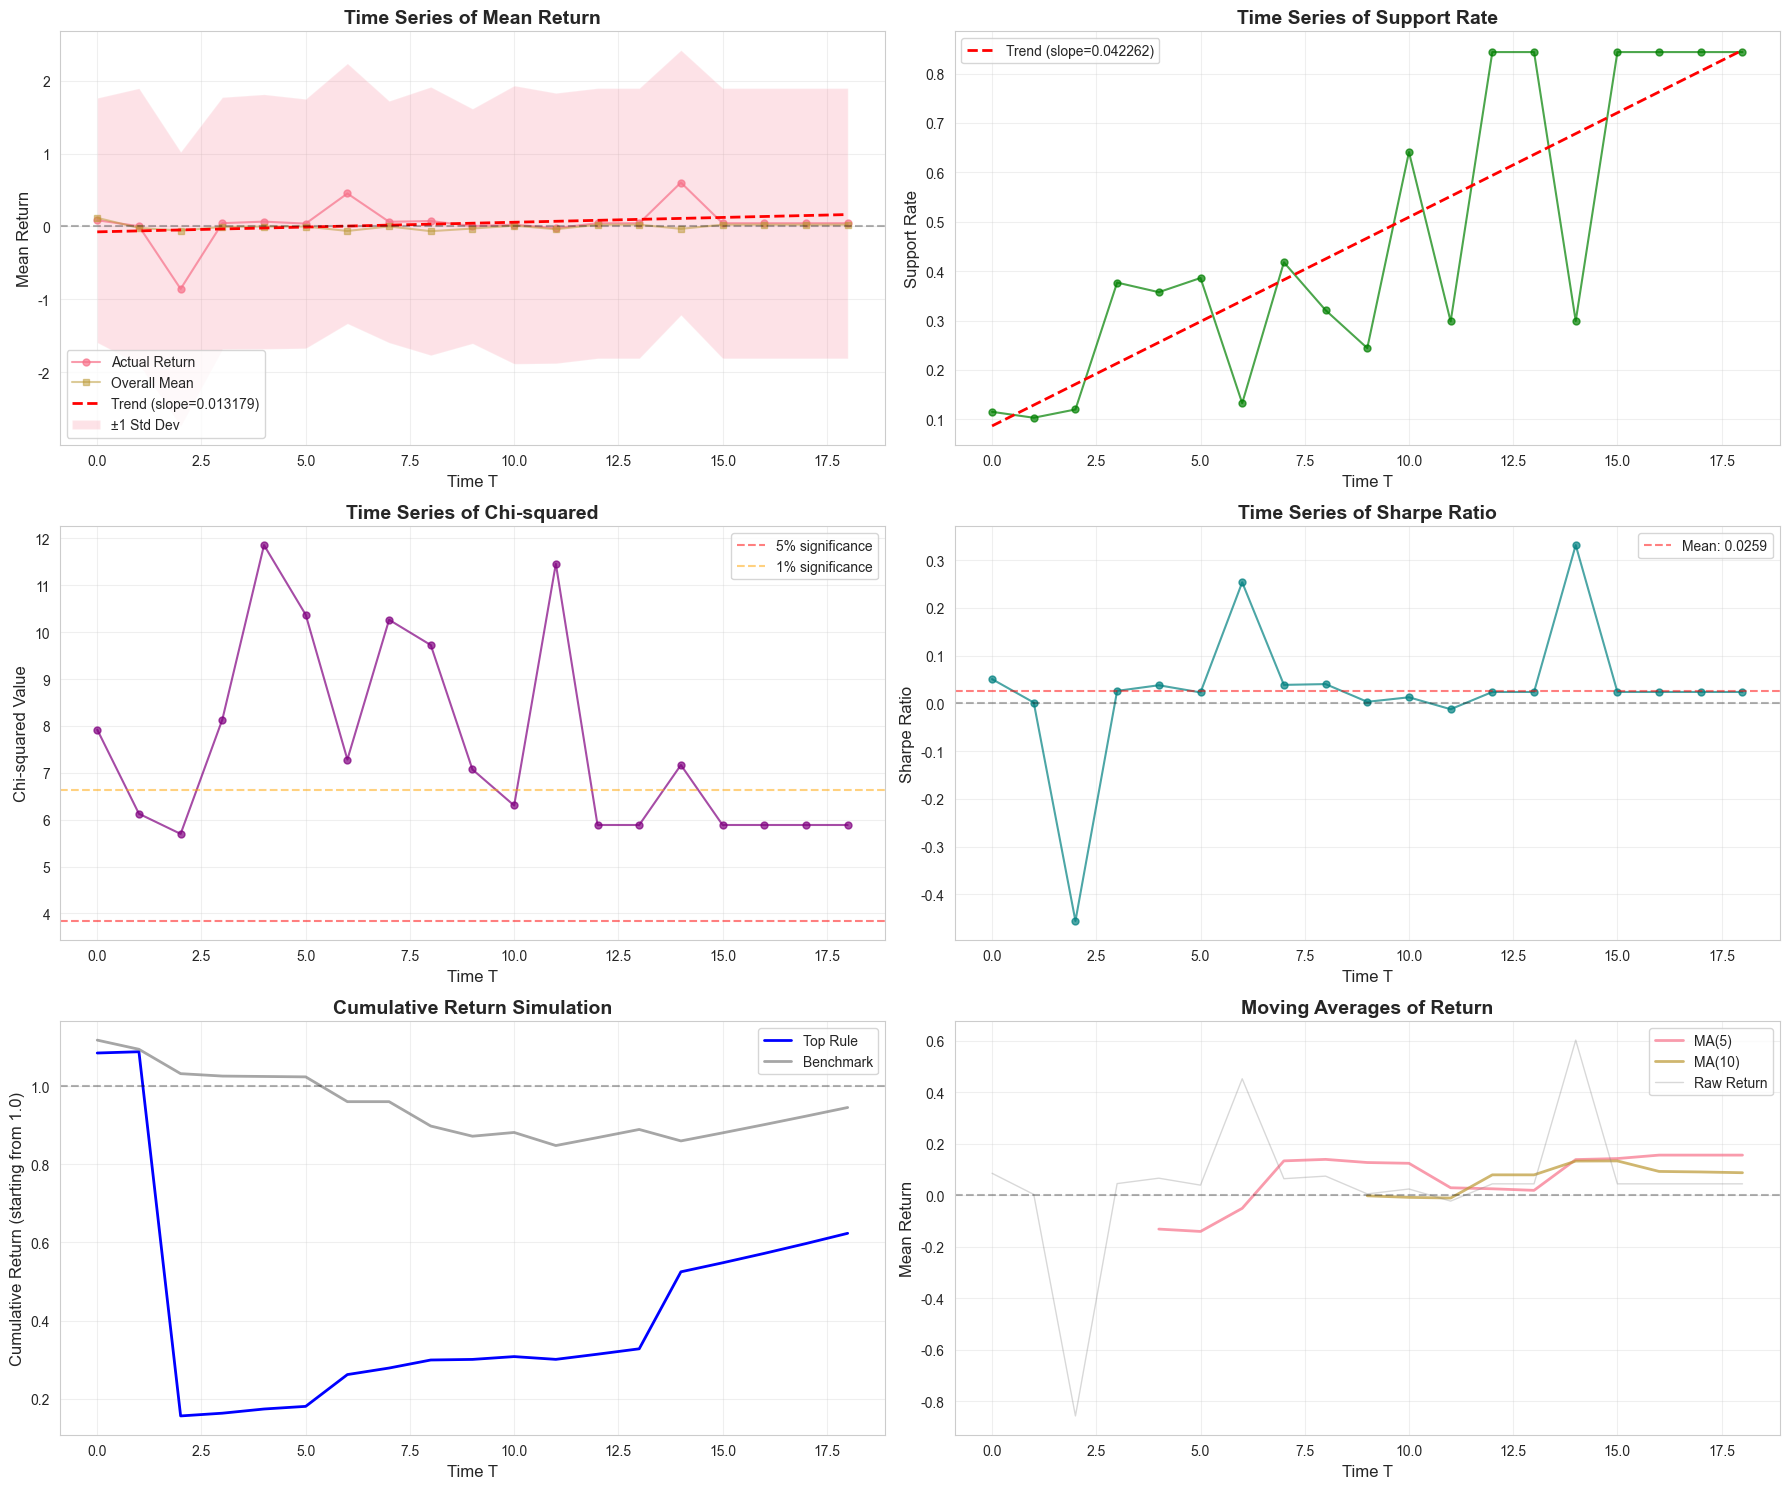


Cumulative Performance:
  Final cumulative return (rule): 0.6233
  Final cumulative return (benchmark): 0.9455
  Outperformance: -0.3222


In [19]:
# 1-1: リターンの時系列推移と回帰分析
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# リターンの時系列プロット
axes[0, 0].plot(top_rule_variations['T'], top_rule_variations['Actual_X_mean'], 
                marker='o', linewidth=1.5, markersize=5, alpha=0.7, label='Actual Return')
axes[0, 0].plot(top_rule_variations['T'], top_rule_variations['X_mean'], 
                marker='s', linewidth=1.5, markersize=4, alpha=0.5, label='Overall Mean')

# トレンドライン（線形回帰）
X_time = top_rule_variations['T'].values.reshape(-1, 1)
y_return = top_rule_variations['Actual_X_mean'].values
reg = LinearRegression().fit(X_time, y_return)
trend = reg.predict(X_time)
axes[0, 0].plot(top_rule_variations['T'], trend, 'r--', linewidth=2, 
                label=f'Trend (slope={reg.coef_[0]:.6f})')

axes[0, 0].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[0, 0].fill_between(top_rule_variations['T'], 
                        top_rule_variations['Actual_X_mean'] - top_rule_variations['Actual_X_sigma'],
                        top_rule_variations['Actual_X_mean'] + top_rule_variations['Actual_X_sigma'],
                        alpha=0.2, label='±1 Std Dev')
axes[0, 0].set_xlabel('Time T', fontsize=12)
axes[0, 0].set_ylabel('Mean Return', fontsize=12)
axes[0, 0].set_title('Time Series of Mean Return', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 回帰統計
r_squared = reg.score(X_time, y_return)
print(f"\nTime Series Regression (Return vs T):")
print(f"  Slope: {reg.coef_[0]:.6f}")
print(f"  Intercept: {reg.intercept_:.4f}")
print(f"  R-squared: {r_squared:.4f}")

# サポート率の時系列推移
axes[0, 1].plot(top_rule_variations['T'], top_rule_variations['support_rate'], 
                marker='o', linewidth=1.5, markersize=5, alpha=0.7, color='green')
y_support = top_rule_variations['support_rate'].values
reg_support = LinearRegression().fit(X_time, y_support)
trend_support = reg_support.predict(X_time)
axes[0, 1].plot(top_rule_variations['T'], trend_support, 'r--', linewidth=2, 
                label=f'Trend (slope={reg_support.coef_[0]:.6f})')
axes[0, 1].set_xlabel('Time T', fontsize=12)
axes[0, 1].set_ylabel('Support Rate', fontsize=12)
axes[0, 1].set_title('Time Series of Support Rate', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Chi-squared値の時系列推移
axes[1, 0].plot(top_rule_variations['T'], top_rule_variations['Chi_squared'], 
                marker='o', linewidth=1.5, markersize=5, alpha=0.7, color='purple')
axes[1, 0].axhline(3.84, color='red', linestyle='--', alpha=0.5, label='5% significance')
axes[1, 0].axhline(6.63, color='orange', linestyle='--', alpha=0.5, label='1% significance')
axes[1, 0].set_xlabel('Time T', fontsize=12)
axes[1, 0].set_ylabel('Chi-squared Value', fontsize=12)
axes[1, 0].set_title('Time Series of Chi-squared', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# シャープレシオの時系列推移
axes[1, 1].plot(top_rule_variations['T'], top_rule_variations['sharpe_ratio'], 
                marker='o', linewidth=1.5, markersize=5, alpha=0.7, color='teal')
axes[1, 1].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[1, 1].axhline(top_rule_variations['sharpe_ratio'].mean(), color='red', linestyle='--', 
                  alpha=0.5, label=f"Mean: {top_rule_variations['sharpe_ratio'].mean():.4f}")
axes[1, 1].set_xlabel('Time T', fontsize=12)
axes[1, 1].set_ylabel('Sharpe Ratio', fontsize=12)
axes[1, 1].set_title('Time Series of Sharpe Ratio', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 累積リターンのシミュレーション
cumulative_return = (1 + top_rule_variations['Actual_X_mean']).cumprod()
cumulative_benchmark = (1 + top_rule_variations['X_mean']).cumprod()
axes[2, 0].plot(top_rule_variations['T'], cumulative_return, 
                linewidth=2, label='Top Rule', color='blue')
axes[2, 0].plot(top_rule_variations['T'], cumulative_benchmark, 
                linewidth=2, label='Benchmark', color='gray', alpha=0.7)
axes[2, 0].axhline(1, color='black', linestyle='--', alpha=0.3)
axes[2, 0].set_xlabel('Time T', fontsize=12)
axes[2, 0].set_ylabel('Cumulative Return (starting from 1.0)', fontsize=12)
axes[2, 0].set_title('Cumulative Return Simulation', fontsize=14, fontweight='bold')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# リターンの移動平均
window_sizes = [5, 10, 20]
for window in window_sizes:
    if len(top_rule_variations) >= window:
        ma = top_rule_variations['Actual_X_mean'].rolling(window=window).mean()
        axes[2, 1].plot(top_rule_variations['T'], ma, linewidth=2, label=f'MA({window})', alpha=0.7)

axes[2, 1].plot(top_rule_variations['T'], top_rule_variations['Actual_X_mean'], 
                alpha=0.3, linewidth=1, color='gray', label='Raw Return')
axes[2, 1].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[2, 1].set_xlabel('Time T', fontsize=12)
axes[2, 1].set_ylabel('Mean Return', fontsize=12)
axes[2, 1].set_title('Moving Averages of Return', fontsize=14, fontweight='bold')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCumulative Performance:")
print(f"  Final cumulative return (rule): {cumulative_return.iloc[-1]:.4f}")
print(f"  Final cumulative return (benchmark): {cumulative_benchmark.iloc[-1]:.4f}")
print(f"  Outperformance: {(cumulative_return.iloc[-1] - cumulative_benchmark.iloc[-1]):.4f}")

## 分析2: リターン分布の詳細分析


Normality Tests:
  Shapiro-Wilk: statistic=0.6232, p-value=0.0000
  Kolmogorov-Smirnov: statistic=0.3484, p-value=0.0145

Distribution Moments:
  Mean: 0.0444
  Std Dev: 0.2689
  Skewness: -1.4435 (left-skewed)
  Kurtosis: 5.8027 (heavy-tailed)

Risk Metrics:
  VaR (95%): -0.1064
  CVaR (95%): -0.8570
  Max Drawdown: -0.8570
  Max Gain: 0.6020


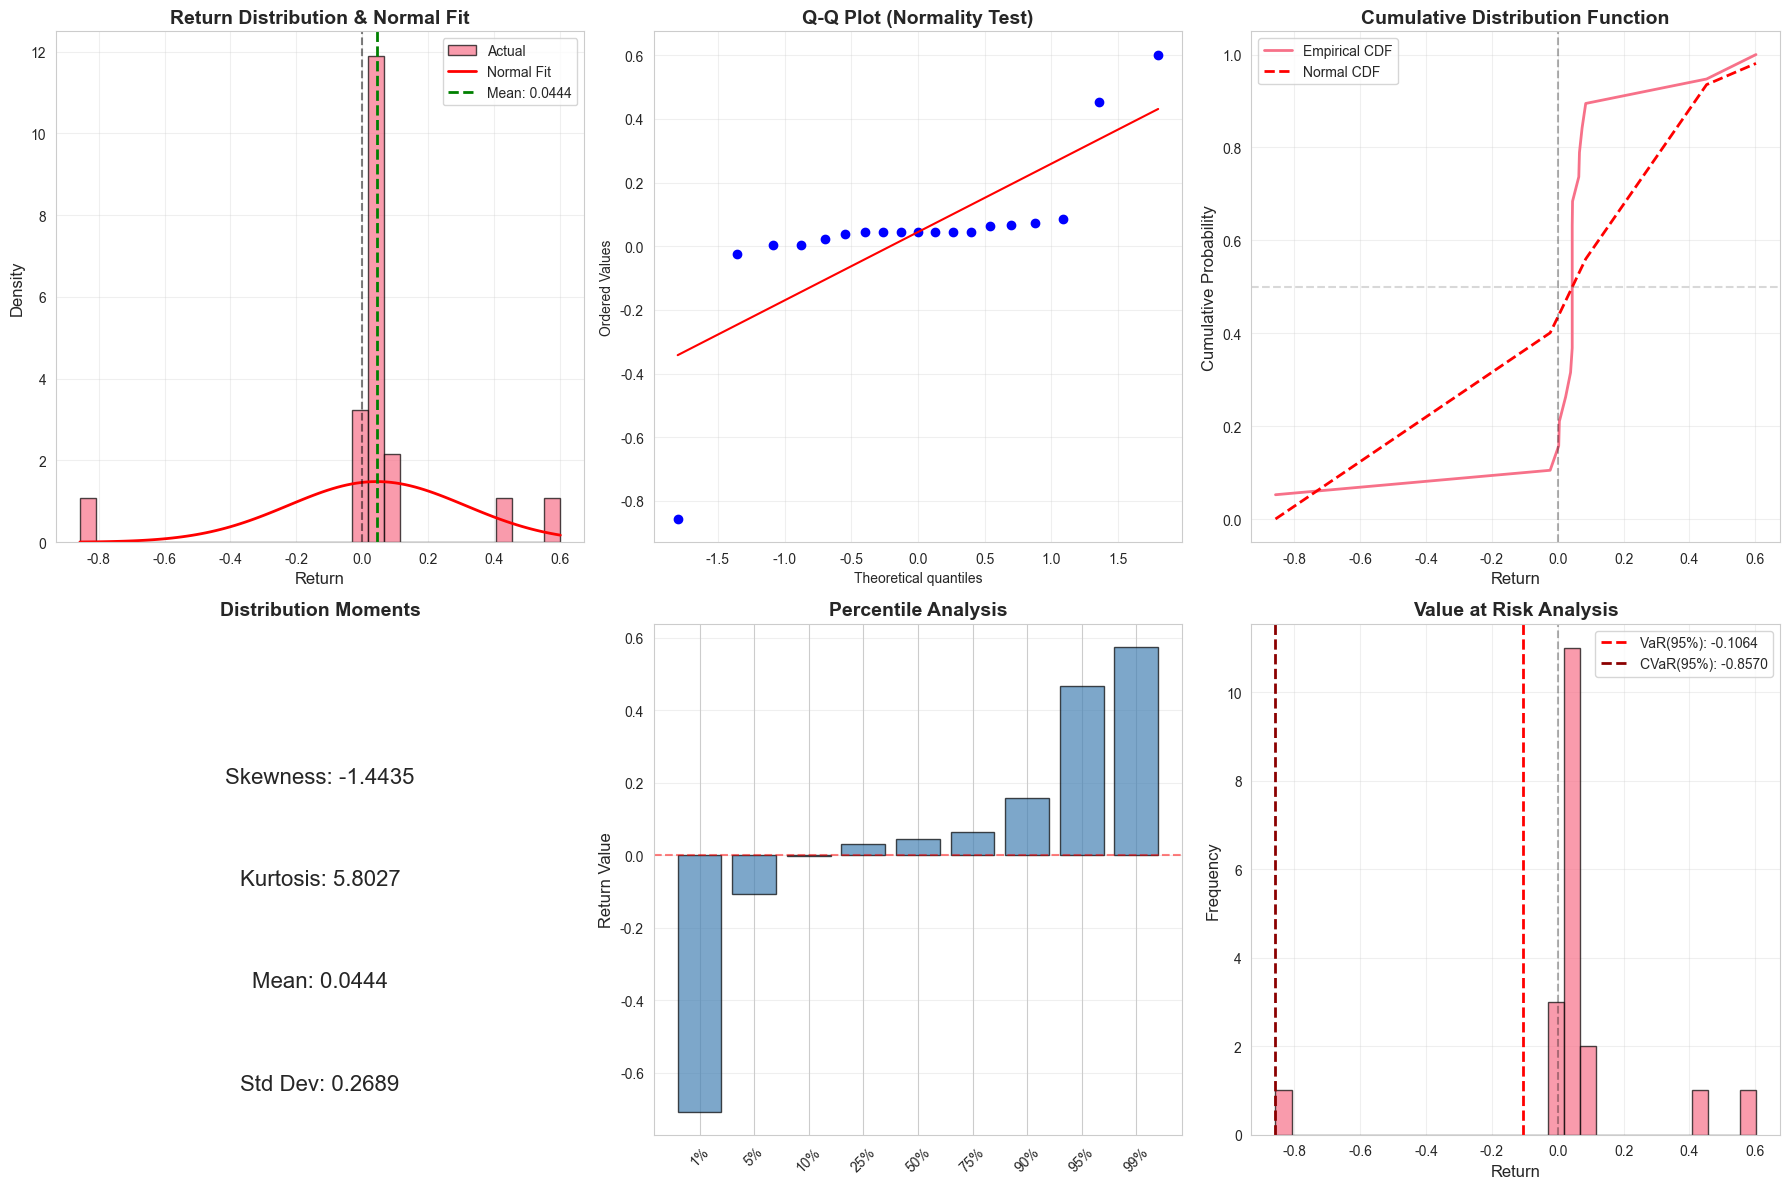

In [17]:
# 2-1: リターン分布の統計的性質
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ヒストグラムと正規分布フィッティング
returns = top_rule_variations['Actual_X_mean']
axes[0, 0].hist(returns, bins=30, density=True, alpha=0.7, edgecolor='black', label='Actual')

# 正規分布をフィット
mu, sigma = returns.mean(), returns.std()
x_range = np.linspace(returns.min(), returns.max(), 100)
axes[0, 0].plot(x_range, norm.pdf(x_range, mu, sigma), 'r-', linewidth=2, label='Normal Fit')
axes[0, 0].axvline(mu, color='green', linestyle='--', linewidth=2, label=f'Mean: {mu:.4f}')
axes[0, 0].axvline(0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Return', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].set_title('Return Distribution & Normal Fit', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Q-Qプロット（正規性の検証）
stats.probplot(returns, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Normality Test)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 正規性の統計検定
shapiro_stat, shapiro_p = stats.shapiro(returns)
ks_stat, ks_p = stats.kstest(returns, 'norm', args=(mu, sigma))

print("\nNormality Tests:")
print(f"  Shapiro-Wilk: statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
print(f"  Kolmogorov-Smirnov: statistic={ks_stat:.4f}, p-value={ks_p:.4f}")

# 累積分布関数
sorted_returns = np.sort(returns)
cumulative = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)
axes[0, 2].plot(sorted_returns, cumulative, linewidth=2, label='Empirical CDF')
axes[0, 2].plot(sorted_returns, norm.cdf(sorted_returns, mu, sigma), 'r--', linewidth=2, label='Normal CDF')
axes[0, 2].axvline(0, color='black', linestyle='--', alpha=0.3)
axes[0, 2].axhline(0.5, color='gray', linestyle='--', alpha=0.3)
axes[0, 2].set_xlabel('Return', fontsize=12)
axes[0, 2].set_ylabel('Cumulative Probability', fontsize=12)
axes[0, 2].set_title('Cumulative Distribution Function', fontsize=14, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 歪度と尖度の可視化
skewness = stats.skew(returns)
kurtosis = stats.kurtosis(returns)

axes[1, 0].text(0.5, 0.7, f'Skewness: {skewness:.4f}', 
                ha='center', va='center', fontsize=16, transform=axes[1, 0].transAxes)
axes[1, 0].text(0.5, 0.5, f'Kurtosis: {kurtosis:.4f}', 
                ha='center', va='center', fontsize=16, transform=axes[1, 0].transAxes)
axes[1, 0].text(0.5, 0.3, f'Mean: {mu:.4f}', 
                ha='center', va='center', fontsize=16, transform=axes[1, 0].transAxes)
axes[1, 0].text(0.5, 0.1, f'Std Dev: {sigma:.4f}', 
                ha='center', va='center', fontsize=16, transform=axes[1, 0].transAxes)
axes[1, 0].set_title('Distribution Moments', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

print(f"\nDistribution Moments:")
print(f"  Mean: {mu:.4f}")
print(f"  Std Dev: {sigma:.4f}")
print(f"  Skewness: {skewness:.4f} ({'right-skewed' if skewness > 0 else 'left-skewed' if skewness < 0 else 'symmetric'})")
print(f"  Kurtosis: {kurtosis:.4f} ({'heavy-tailed' if kurtosis > 0 else 'light-tailed'})")

# パーセンタイル分析
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
percentile_values = np.percentile(returns, percentiles)

axes[1, 1].bar(range(len(percentiles)), percentile_values, 
               edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].set_xticks(range(len(percentiles)))
axes[1, 1].set_xticklabels([f'{p}%' for p in percentiles], rotation=45)
axes[1, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_ylabel('Return Value', fontsize=12)
axes[1, 1].set_title('Percentile Analysis', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# VaR (Value at Risk) と CVaR (Conditional VaR)
var_95 = np.percentile(returns, 5)  # 5パーセンタイル = 95% VaR
cvar_95 = returns[returns <= var_95].mean()

axes[1, 2].hist(returns, bins=30, alpha=0.7, edgecolor='black')
axes[1, 2].axvline(var_95, color='red', linestyle='--', linewidth=2, 
                  label=f'VaR(95%): {var_95:.4f}')
axes[1, 2].axvline(cvar_95, color='darkred', linestyle='--', linewidth=2, 
                  label=f'CVaR(95%): {cvar_95:.4f}')
axes[1, 2].axvline(0, color='black', linestyle='--', alpha=0.3)
axes[1, 2].set_xlabel('Return', fontsize=12)
axes[1, 2].set_ylabel('Frequency', fontsize=12)
axes[1, 2].set_title('Value at Risk Analysis', fontsize=14, fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

print(f"\nRisk Metrics:")
print(f"  VaR (95%): {var_95:.4f}")
print(f"  CVaR (95%): {cvar_95:.4f}")
print(f"  Max Drawdown: {returns.min():.4f}")
print(f"  Max Gain: {returns.max():.4f}")

plt.tight_layout()
plt.show()

## 分析3: 時期依存性の詳細分析

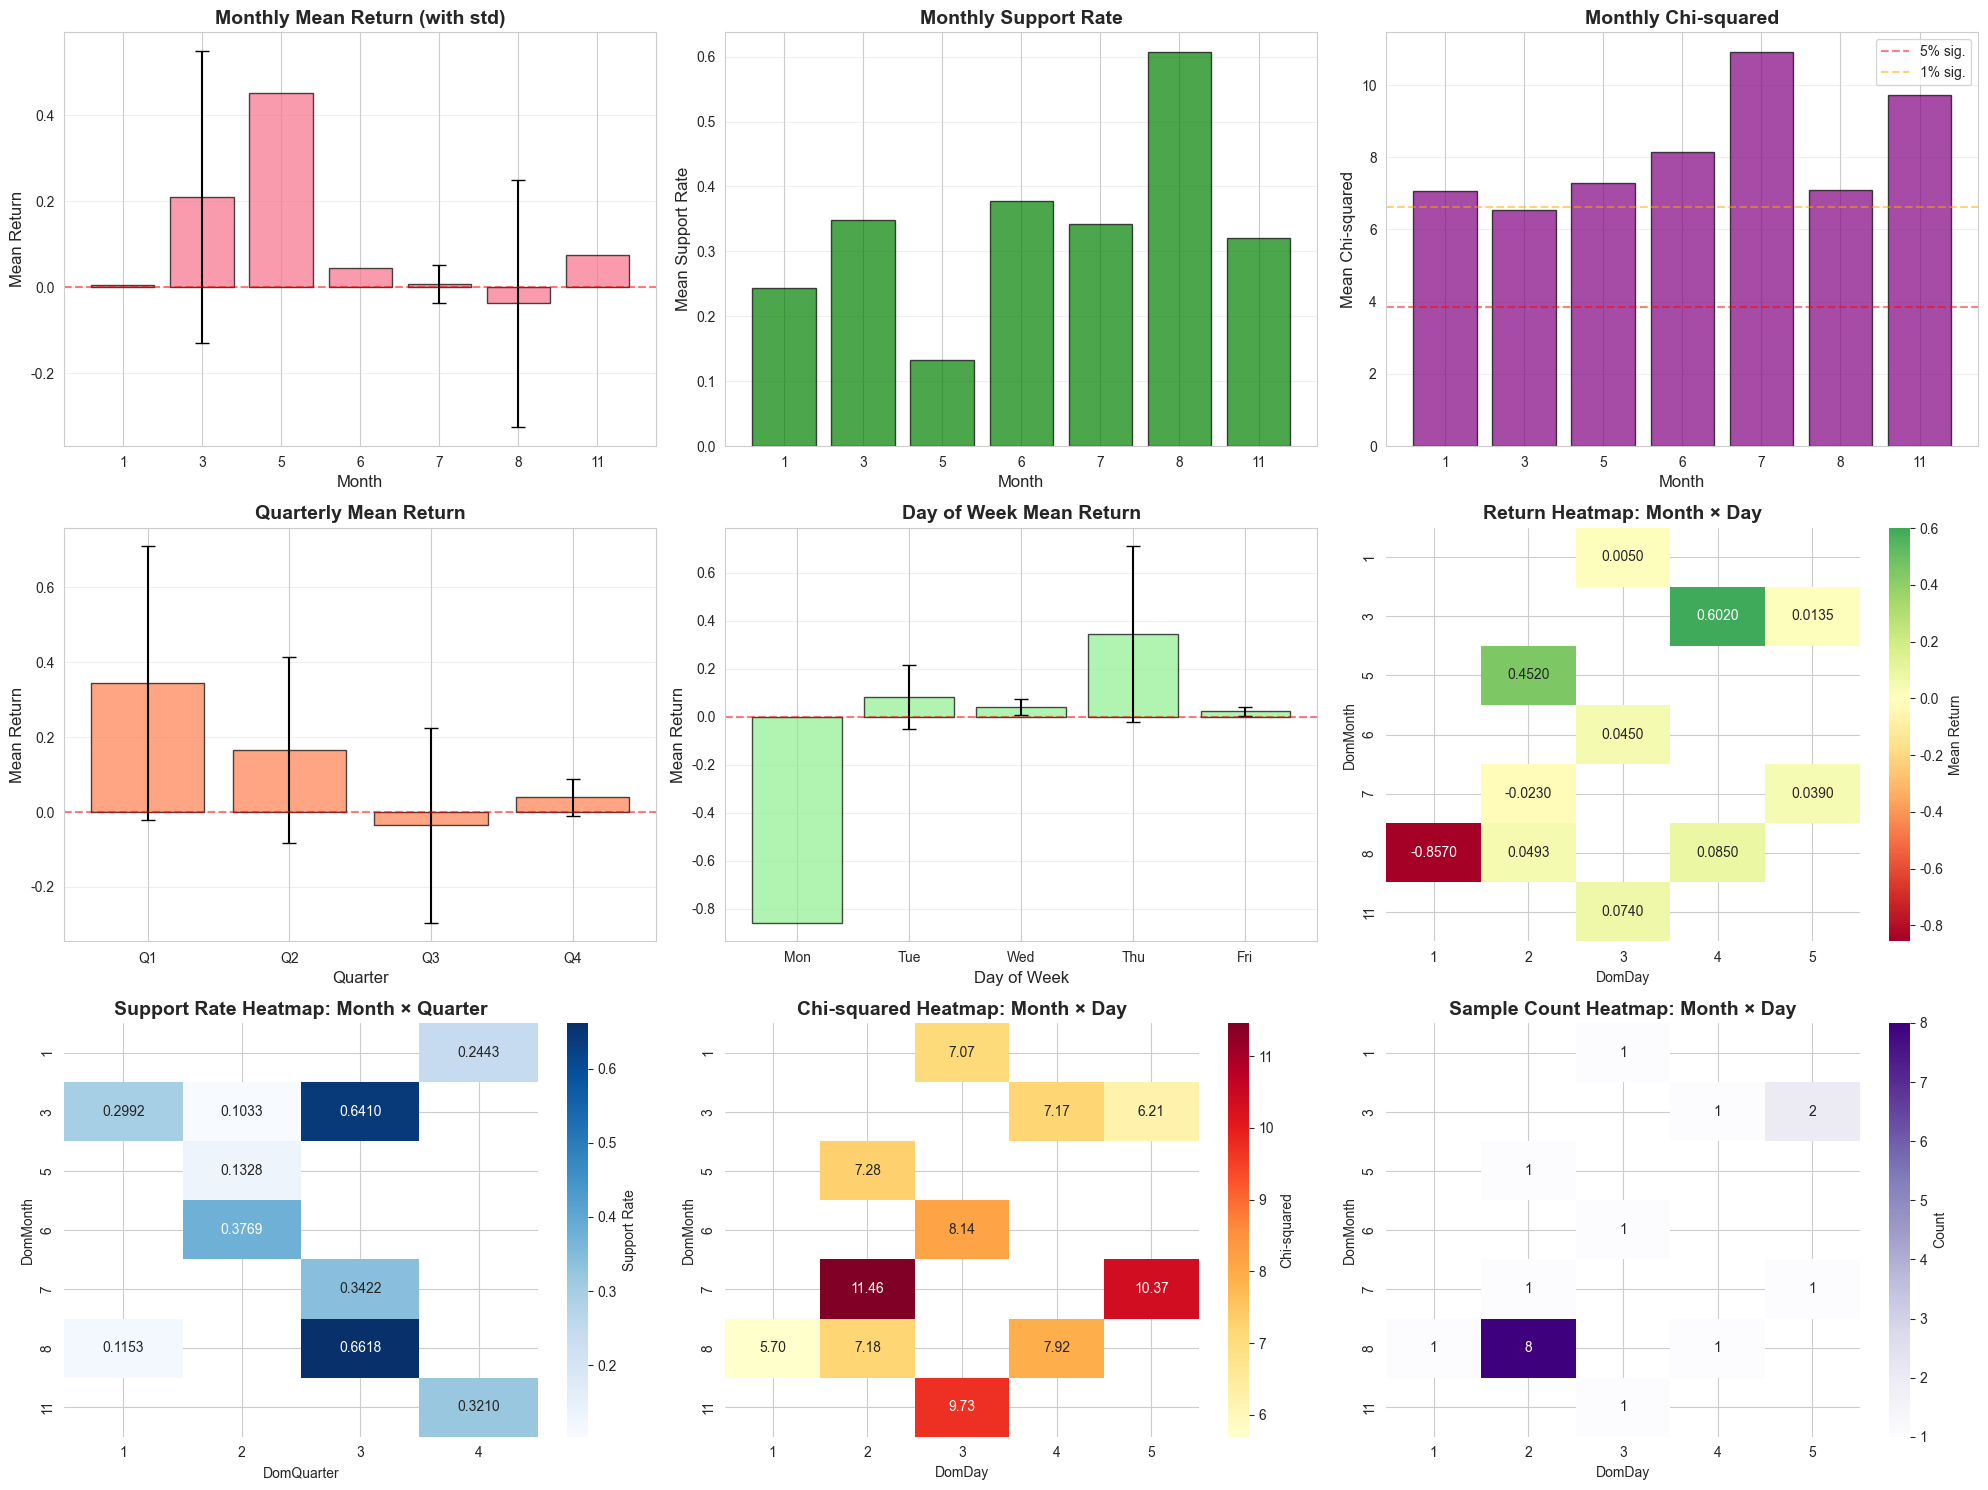


TEMPORAL PATTERN ANALYSIS

ANOVA (Monthly Return Differences):
  F-statistic: 0.6542
  P-value: 0.6873
  Result: No significant monthly effect (p >= 0.05)

Best performing month: 5 (return: 0.4520)
Worst performing month: 8 (return: -0.0378)


In [20]:
# 3-1: 時期別の詳細パフォーマンス
if all(col in top_rule_variations.columns for col in ['DomMonth', 'DomQuarter', 'DomDay']):
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    
    # 月別の詳細分析
    month_stats = top_rule_variations.groupby('DomMonth').agg({
        'Actual_X_mean': ['mean', 'std', 'count', 'min', 'max'],
        'support_rate': 'mean',
        'Chi_squared': 'mean'
    })
    
    # 月別平均リターン
    months = month_stats.index
    mean_returns = month_stats[('Actual_X_mean', 'mean')].values
    std_returns = month_stats[('Actual_X_mean', 'std')].values
    
    axes[0, 0].bar(range(len(months)), mean_returns, 
                   yerr=std_returns, capsize=5, alpha=0.7, edgecolor='black')
    axes[0, 0].set_xticks(range(len(months)))
    axes[0, 0].set_xticklabels(months)
    axes[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[0, 0].set_xlabel('Month', fontsize=12)
    axes[0, 0].set_ylabel('Mean Return', fontsize=12)
    axes[0, 0].set_title('Monthly Mean Return (with std)', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # 月別サポート率
    support_by_month = month_stats[('support_rate', 'mean')].values
    axes[0, 1].bar(range(len(months)), support_by_month, 
                   alpha=0.7, edgecolor='black', color='green')
    axes[0, 1].set_xticks(range(len(months)))
    axes[0, 1].set_xticklabels(months)
    axes[0, 1].set_xlabel('Month', fontsize=12)
    axes[0, 1].set_ylabel('Mean Support Rate', fontsize=12)
    axes[0, 1].set_title('Monthly Support Rate', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 月別Chi-squared
    chi_by_month = month_stats[('Chi_squared', 'mean')].values
    axes[0, 2].bar(range(len(months)), chi_by_month, 
                   alpha=0.7, edgecolor='black', color='purple')
    axes[0, 2].set_xticks(range(len(months)))
    axes[0, 2].set_xticklabels(months)
    axes[0, 2].axhline(3.84, color='red', linestyle='--', alpha=0.5, label='5% sig.')
    axes[0, 2].axhline(6.63, color='orange', linestyle='--', alpha=0.5, label='1% sig.')
    axes[0, 2].set_xlabel('Month', fontsize=12)
    axes[0, 2].set_ylabel('Mean Chi-squared', fontsize=12)
    axes[0, 2].set_title('Monthly Chi-squared', fontsize=14, fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3, axis='y')
    
    # 四半期別分析
    quarter_stats = top_rule_variations.groupby('DomQuarter').agg({
        'Actual_X_mean': ['mean', 'std', 'count'],
        'support_rate': 'mean',
        'Chi_squared': 'mean'
    })
    
    quarters = quarter_stats.index
    quarter_returns = quarter_stats[('Actual_X_mean', 'mean')].values
    quarter_std = quarter_stats[('Actual_X_mean', 'std')].values
    
    axes[1, 0].bar(range(len(quarters)), quarter_returns, 
                   yerr=quarter_std, capsize=5, alpha=0.7, edgecolor='black', color='coral')
    axes[1, 0].set_xticks(range(len(quarters)))
    axes[1, 0].set_xticklabels([f'Q{int(q)}' for q in quarters])
    axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].set_xlabel('Quarter', fontsize=12)
    axes[1, 0].set_ylabel('Mean Return', fontsize=12)
    axes[1, 0].set_title('Quarterly Mean Return', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 曜日別分析
    day_stats = top_rule_variations.groupby('DomDay').agg({
        'Actual_X_mean': ['mean', 'std', 'count'],
        'support_rate': 'mean'
    })
    
    days = day_stats.index
    day_returns = day_stats[('Actual_X_mean', 'mean')].values
    day_std = day_stats[('Actual_X_mean', 'std')].values
    
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
    axes[1, 1].bar(range(len(days)), day_returns, 
                   yerr=day_std, capsize=5, alpha=0.7, edgecolor='black', color='lightgreen')
    axes[1, 1].set_xticks(range(len(days)))
    axes[1, 1].set_xticklabels([day_names[int(d)-1] if int(d) <= 5 else f'D{int(d)}' for d in days])
    axes[1, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Day of Week', fontsize=12)
    axes[1, 1].set_ylabel('Mean Return', fontsize=12)
    axes[1, 1].set_title('Day of Week Mean Return', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # 月×曜日のヒートマップ（リターン）
    pivot_return = top_rule_variations.pivot_table(
        values='Actual_X_mean', index='DomMonth', columns='DomDay', aggfunc='mean'
    )
    sns.heatmap(pivot_return, annot=True, fmt='.4f', cmap='RdYlGn', center=0, 
                cbar_kws={'label': 'Mean Return'}, ax=axes[1, 2])
    axes[1, 2].set_title('Return Heatmap: Month × Day', fontsize=14, fontweight='bold')
    
    # 月×四半期のヒートマップ（サポート率）
    pivot_support = top_rule_variations.pivot_table(
        values='support_rate', index='DomMonth', columns='DomQuarter', aggfunc='mean'
    )
    sns.heatmap(pivot_support, annot=True, fmt='.4f', cmap='Blues', 
                cbar_kws={'label': 'Support Rate'}, ax=axes[2, 0])
    axes[2, 0].set_title('Support Rate Heatmap: Month × Quarter', fontsize=14, fontweight='bold')
    
    # 月×曜日のヒートマップ（Chi-squared）
    pivot_chi = top_rule_variations.pivot_table(
        values='Chi_squared', index='DomMonth', columns='DomDay', aggfunc='mean'
    )
    sns.heatmap(pivot_chi, annot=True, fmt='.2f', cmap='YlOrRd', 
                cbar_kws={'label': 'Chi-squared'}, ax=axes[2, 1])
    axes[2, 1].set_title('Chi-squared Heatmap: Month × Day', fontsize=14, fontweight='bold')
    
    # サンプル数のヒートマップ
    pivot_count = top_rule_variations.pivot_table(
        values='Actual_X_mean', index='DomMonth', columns='DomDay', aggfunc='count'
    )
    sns.heatmap(pivot_count, annot=True, fmt='.0f', cmap='Purples', 
                cbar_kws={'label': 'Count'}, ax=axes[2, 2])
    axes[2, 2].set_title('Sample Count Heatmap: Month × Day', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 統計的検定（月間の差）
    print("\n" + "="*80)
    print("TEMPORAL PATTERN ANALYSIS")
    print("="*80)
    
    # ANOVA（月別リターンの差）
    month_groups = [group['Actual_X_mean'].values for name, group in top_rule_variations.groupby('DomMonth')]
    f_stat, p_value = stats.f_oneway(*month_groups)
    print(f"\nANOVA (Monthly Return Differences):")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"  Result: Significant monthly effect (p < 0.05)")
    else:
        print(f"  Result: No significant monthly effect (p >= 0.05)")
    
    # 最良・最悪の月を特定
    best_month = month_stats[('Actual_X_mean', 'mean')].idxmax()
    worst_month = month_stats[('Actual_X_mean', 'mean')].idxmin()
    print(f"\nBest performing month: {best_month} (return: {month_stats.loc[best_month, ('Actual_X_mean', 'mean')]:.4f})")
    print(f"Worst performing month: {worst_month} (return: {month_stats.loc[worst_month, ('Actual_X_mean', 'mean')]:.4f})")

## 分析4: 安定性と劣化の分析

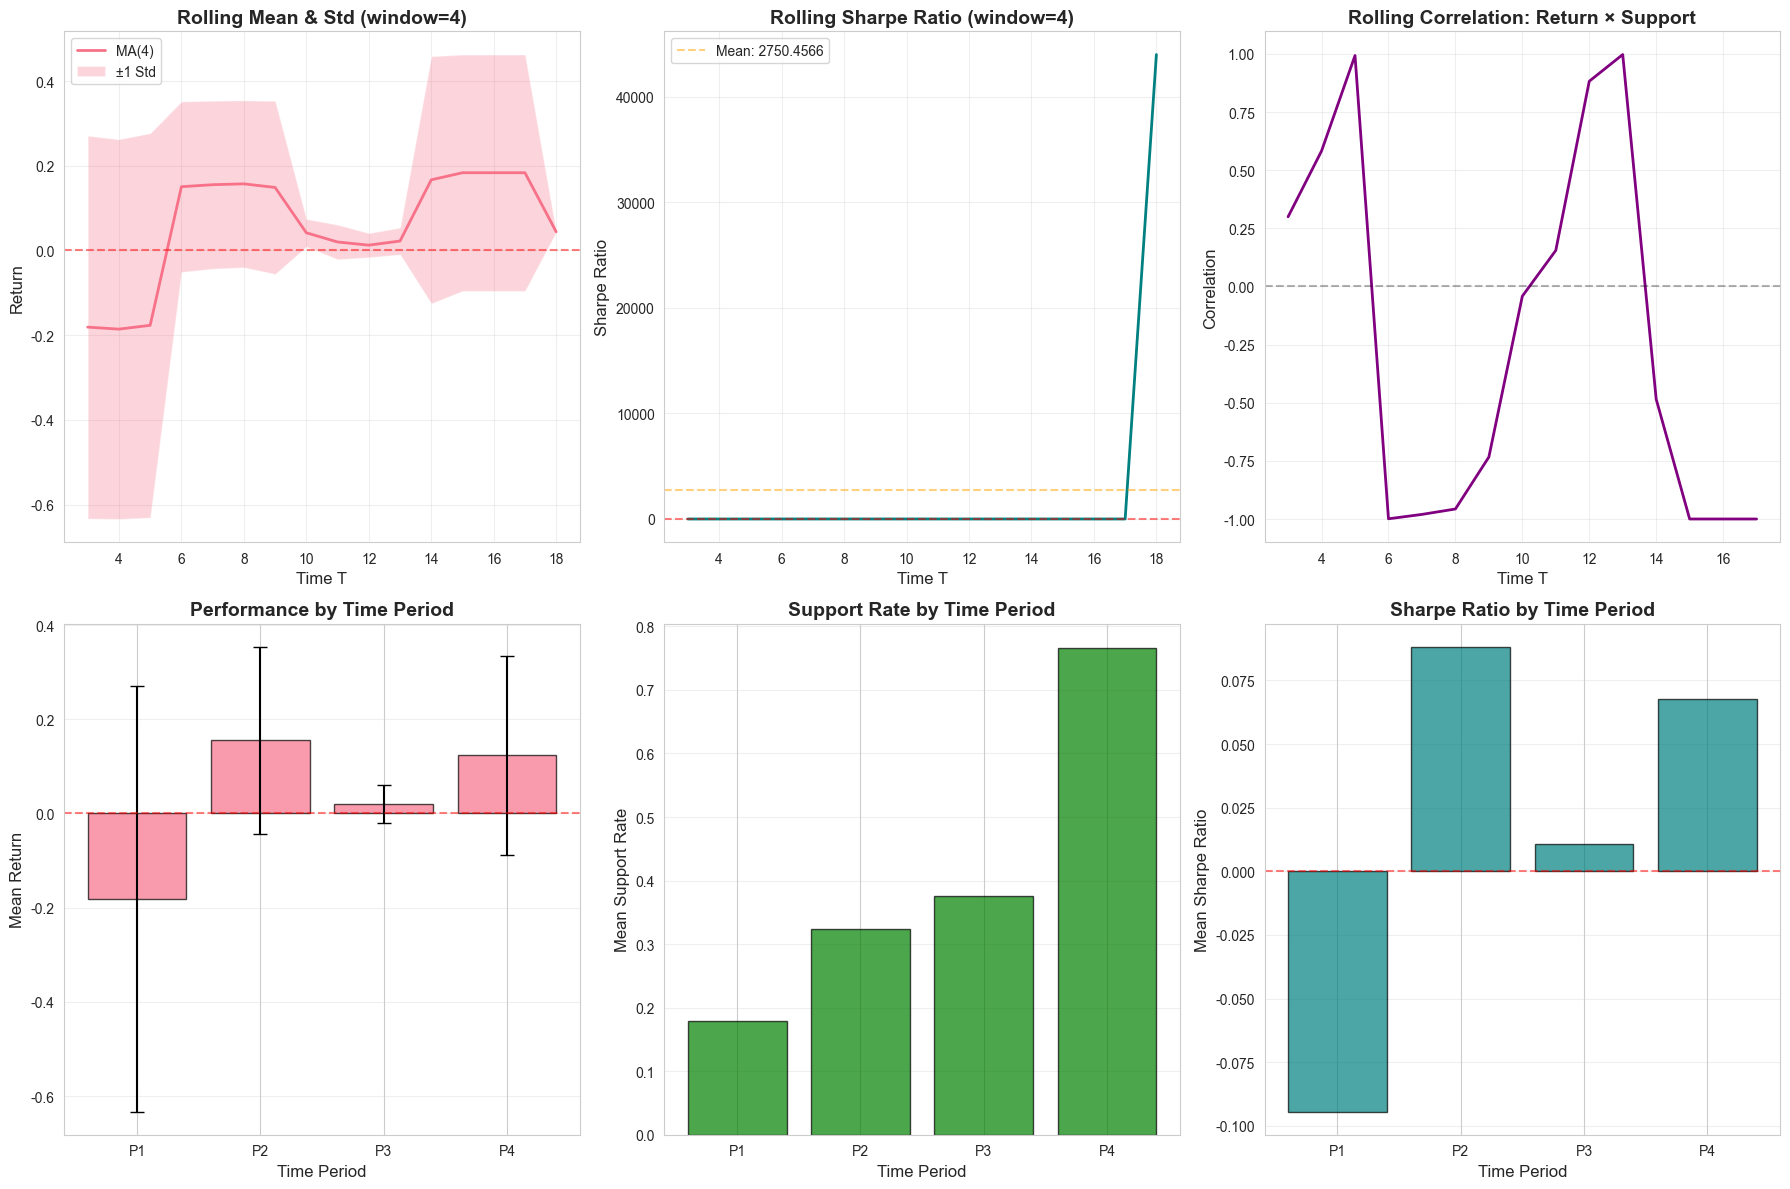


STABILITY & DEGRADATION ANALYSIS

Period-wise Statistics:
period  mean_return  std_return  mean_support  mean_chi    sharpe
    P1    -0.181000    0.451909      0.178900  6.970250 -0.094392
    P2     0.155250    0.198214      0.323600  9.945000  0.088143
    P3     0.020000    0.040849      0.376150  8.640000  0.010874
    P4     0.123714    0.210904      0.765743  6.069857  0.067684

Time Trend Analysis:
  Slope: 0.013179
  Interpretation: Rule is improving over time


In [21]:
# 4-1: ルールの劣化・改善トレンド分析
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 時間窓での移動統計
window = min(20, len(top_rule_variations) // 4)

if window >= 3:
    # 移動平均と移動標準偏差
    rolling_mean = top_rule_variations['Actual_X_mean'].rolling(window=window).mean()
    rolling_std = top_rule_variations['Actual_X_mean'].rolling(window=window).std()
    
    axes[0, 0].plot(top_rule_variations['T'], rolling_mean, linewidth=2, label=f'MA({window})')
    axes[0, 0].fill_between(top_rule_variations['T'], 
                           rolling_mean - rolling_std,
                           rolling_mean + rolling_std,
                           alpha=0.3, label='±1 Std')
    axes[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[0, 0].set_xlabel('Time T', fontsize=12)
    axes[0, 0].set_ylabel('Return', fontsize=12)
    axes[0, 0].set_title(f'Rolling Mean & Std (window={window})', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 移動シャープレシオ
    rolling_sharpe = rolling_mean / (rolling_std + 1e-6)
    axes[0, 1].plot(top_rule_variations['T'], rolling_sharpe, linewidth=2, color='teal')
    axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[0, 1].axhline(rolling_sharpe.mean(), color='orange', linestyle='--', 
                      alpha=0.5, label=f'Mean: {rolling_sharpe.mean():.4f}')
    axes[0, 1].set_xlabel('Time T', fontsize=12)
    axes[0, 1].set_ylabel('Sharpe Ratio', fontsize=12)
    axes[0, 1].set_title(f'Rolling Sharpe Ratio (window={window})', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 移動相関（リターンとサポート率）
    rolling_corr = top_rule_variations['Actual_X_mean'].rolling(window=window).corr(
        top_rule_variations['support_rate']
    )
    axes[0, 2].plot(top_rule_variations['T'], rolling_corr, linewidth=2, color='purple')
    axes[0, 2].axhline(0, color='black', linestyle='--', alpha=0.3)
    axes[0, 2].set_xlabel('Time T', fontsize=12)
    axes[0, 2].set_ylabel('Correlation', fontsize=12)
    axes[0, 2].set_title('Rolling Correlation: Return × Support', fontsize=14, fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3)

# 時系列分割によるパフォーマンス比較
n_splits = 4
split_size = len(top_rule_variations) // n_splits
split_stats = []

for i in range(n_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < n_splits - 1 else len(top_rule_variations)
    split_data = top_rule_variations.iloc[start_idx:end_idx]
    
    split_stats.append({
        'period': f'P{i+1}',
        'mean_return': split_data['Actual_X_mean'].mean(),
        'std_return': split_data['Actual_X_mean'].std(),
        'mean_support': split_data['support_rate'].mean(),
        'mean_chi': split_data['Chi_squared'].mean(),
        'sharpe': split_data['sharpe_ratio'].mean()
    })

split_df = pd.DataFrame(split_stats)

# 期間別リターン
axes[1, 0].bar(range(n_splits), split_df['mean_return'], 
               yerr=split_df['std_return'], capsize=5, alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(range(n_splits))
axes[1, 0].set_xticklabels(split_df['period'])
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Time Period', fontsize=12)
axes[1, 0].set_ylabel('Mean Return', fontsize=12)
axes[1, 0].set_title('Performance by Time Period', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 期間別サポート率
axes[1, 1].bar(range(n_splits), split_df['mean_support'], 
               alpha=0.7, edgecolor='black', color='green')
axes[1, 1].set_xticks(range(n_splits))
axes[1, 1].set_xticklabels(split_df['period'])
axes[1, 1].set_xlabel('Time Period', fontsize=12)
axes[1, 1].set_ylabel('Mean Support Rate', fontsize=12)
axes[1, 1].set_title('Support Rate by Time Period', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 期間別シャープレシオ
axes[1, 2].bar(range(n_splits), split_df['sharpe'], 
               alpha=0.7, edgecolor='black', color='teal')
axes[1, 2].set_xticks(range(n_splits))
axes[1, 2].set_xticklabels(split_df['period'])
axes[1, 2].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 2].set_xlabel('Time Period', fontsize=12)
axes[1, 2].set_ylabel('Mean Sharpe Ratio', fontsize=12)
axes[1, 2].set_title('Sharpe Ratio by Time Period', fontsize=14, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("STABILITY & DEGRADATION ANALYSIS")
print("="*80)
print("\nPeriod-wise Statistics:")
print(split_df.to_string(index=False))

# トレンド検定（リターンが時間とともに減少しているか）
X_time = top_rule_variations['T'].values.reshape(-1, 1)
y_return = top_rule_variations['Actual_X_mean'].values
reg = LinearRegression().fit(X_time, y_return)

print(f"\nTime Trend Analysis:")
print(f"  Slope: {reg.coef_[0]:.6f}")
if reg.coef_[0] < 0:
    print(f"  Interpretation: Rule is degrading over time")
elif reg.coef_[0] > 0:
    print(f"  Interpretation: Rule is improving over time")
else:
    print(f"  Interpretation: Rule is stable over time")

## 分析5: 予測性能の評価

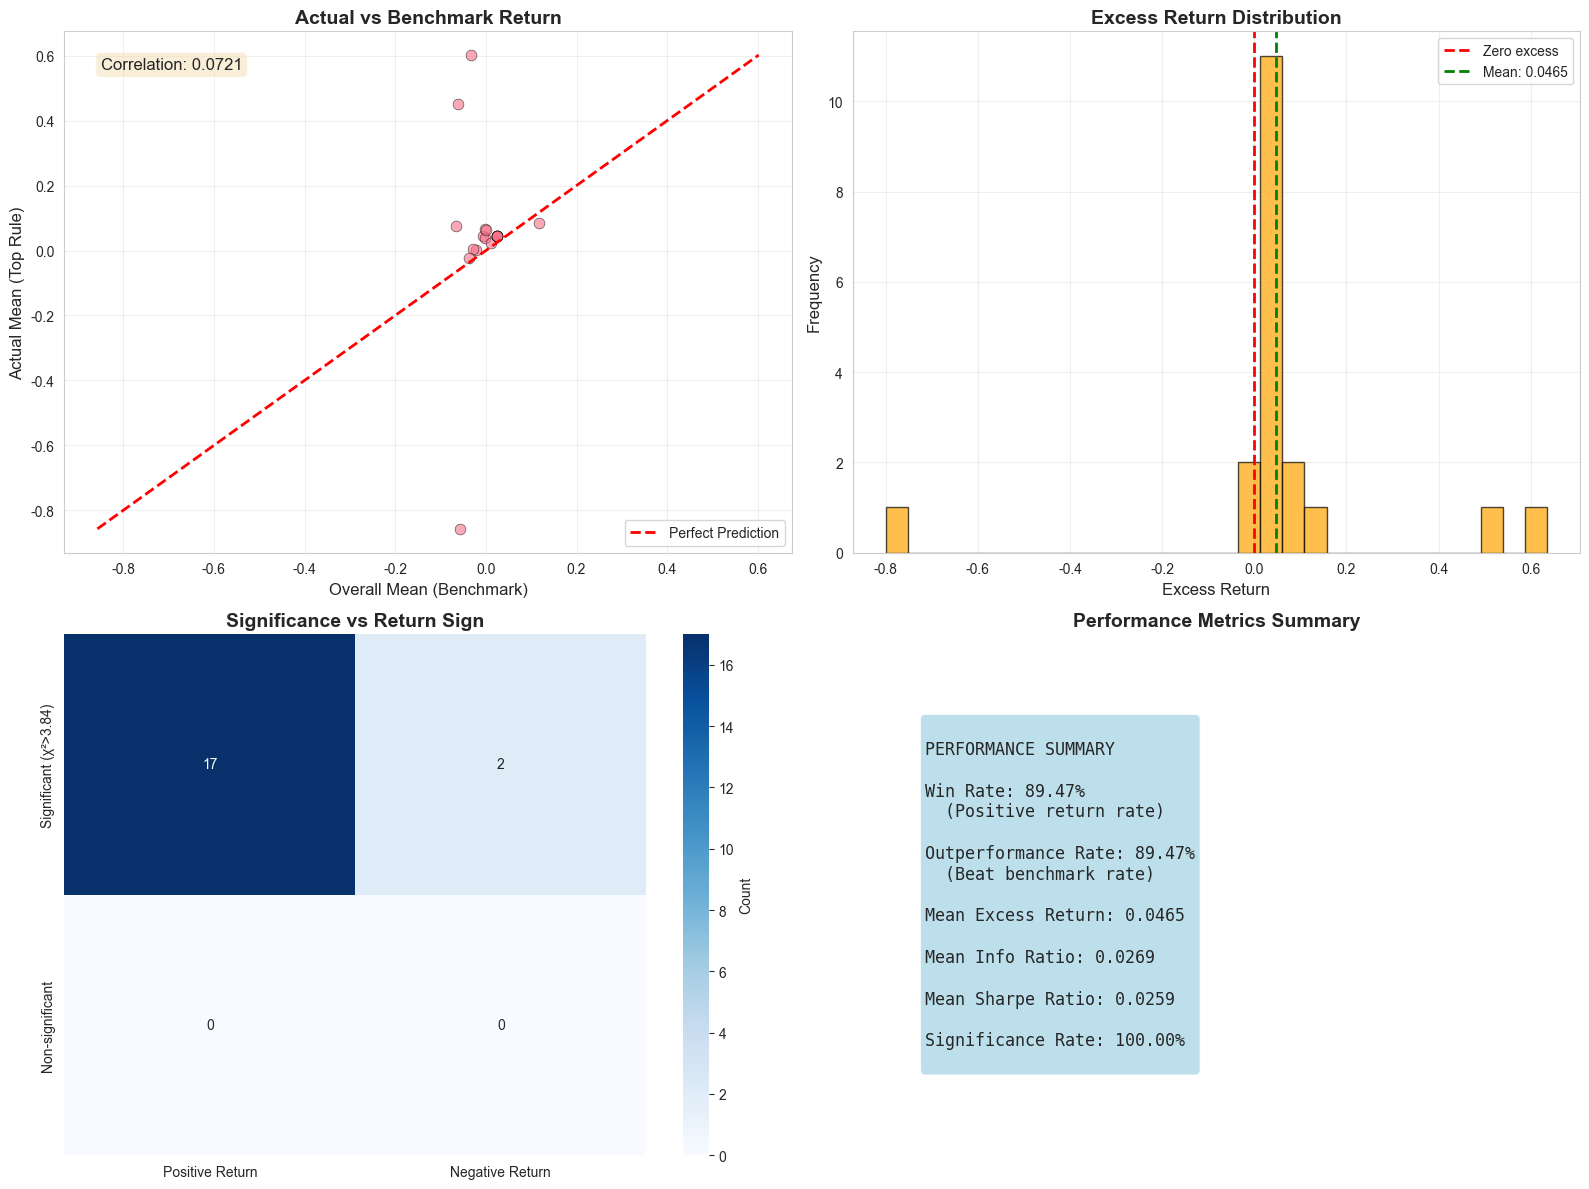


PREDICTIVE PERFORMANCE EVALUATION

Win Rate: 89.47%
Outperformance Rate: 89.47%
Mean Excess Return: 0.0465
Correlation with Benchmark: 0.0721

Significance Breakdown:
  Significant & Positive: 17 (89.5%)
  Significant & Negative: 2 (10.5%)
  Non-significant & Positive: 0 (0.0%)
  Non-significant & Negative: 0 (0.0%)


In [22]:
# 5-1: ルールの予測精度分析
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 実際のリターン vs 予測リターン（全体平均との比較）
axes[0, 0].scatter(top_rule_variations['X_mean'], top_rule_variations['Actual_X_mean'], 
                   alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
# 完全予測ライン
min_val = min(top_rule_variations['X_mean'].min(), top_rule_variations['Actual_X_mean'].min())
max_val = max(top_rule_variations['X_mean'].max(), top_rule_variations['Actual_X_mean'].max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Overall Mean (Benchmark)', fontsize=12)
axes[0, 0].set_ylabel('Actual Mean (Top Rule)', fontsize=12)
axes[0, 0].set_title('Actual vs Benchmark Return', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 相関分析
corr = top_rule_variations['Actual_X_mean'].corr(top_rule_variations['X_mean'])
axes[0, 0].text(0.05, 0.95, f'Correlation: {corr:.4f}', 
                transform=axes[0, 0].transAxes, fontsize=12, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 超過リターンの分布
axes[0, 1].hist(top_rule_variations['excess_return'], bins=30, 
                alpha=0.7, edgecolor='black', color='orange')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero excess')
axes[0, 1].axvline(top_rule_variations['excess_return'].mean(), 
                  color='green', linestyle='--', linewidth=2, 
                  label=f"Mean: {top_rule_variations['excess_return'].mean():.4f}")
axes[0, 1].set_xlabel('Excess Return', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Excess Return Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 勝率の計算（リターンが正の割合）
win_rate = (top_rule_variations['Actual_X_mean'] > 0).sum() / len(top_rule_variations) * 100
outperform_rate = (top_rule_variations['excess_return'] > 0).sum() / len(top_rule_variations) * 100

# 勝率と統計的有意性の関係
sig_and_positive = ((top_rule_variations['Chi_squared'] > 3.84) & 
                    (top_rule_variations['Actual_X_mean'] > 0)).sum()
sig_and_negative = ((top_rule_variations['Chi_squared'] > 3.84) & 
                    (top_rule_variations['Actual_X_mean'] < 0)).sum()
nonsig_and_positive = ((top_rule_variations['Chi_squared'] <= 3.84) & 
                       (top_rule_variations['Actual_X_mean'] > 0)).sum()
nonsig_and_negative = ((top_rule_variations['Chi_squared'] <= 3.84) & 
                       (top_rule_variations['Actual_X_mean'] < 0)).sum()

confusion_data = np.array([
    [sig_and_positive, sig_and_negative],
    [nonsig_and_positive, nonsig_and_negative]
])

sns.heatmap(confusion_data, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Positive Return', 'Negative Return'],
            yticklabels=['Significant (χ²>3.84)', 'Non-significant'],
            ax=axes[1, 0], cbar_kws={'label': 'Count'})
axes[1, 0].set_title('Significance vs Return Sign', fontsize=14, fontweight='bold')

# パフォーマンスサマリー
summary_text = f"""
PERFORMANCE SUMMARY

Win Rate: {win_rate:.2f}%
  (Positive return rate)

Outperformance Rate: {outperform_rate:.2f}%
  (Beat benchmark rate)

Mean Excess Return: {top_rule_variations['excess_return'].mean():.4f}

Mean Info Ratio: {top_rule_variations['info_ratio'].mean():.4f}

Mean Sharpe Ratio: {top_rule_variations['sharpe_ratio'].mean():.4f}

Significance Rate: {(top_rule_variations['Chi_squared'] > 3.84).sum() / len(top_rule_variations) * 100:.2f}%
"""

axes[1, 1].text(0.1, 0.5, summary_text, 
                transform=axes[1, 1].transAxes,
                fontsize=12, verticalalignment='center',
                family='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
axes[1, 1].set_title('Performance Metrics Summary', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("PREDICTIVE PERFORMANCE EVALUATION")
print("="*80)
print(f"\nWin Rate: {win_rate:.2f}%")
print(f"Outperformance Rate: {outperform_rate:.2f}%")
print(f"Mean Excess Return: {top_rule_variations['excess_return'].mean():.4f}")
print(f"Correlation with Benchmark: {corr:.4f}")
print(f"\nSignificance Breakdown:")
print(f"  Significant & Positive: {sig_and_positive} ({sig_and_positive/len(top_rule_variations)*100:.1f}%)")
print(f"  Significant & Negative: {sig_and_negative} ({sig_and_negative/len(top_rule_variations)*100:.1f}%)")
print(f"  Non-significant & Positive: {nonsig_and_positive} ({nonsig_and_positive/len(top_rule_variations)*100:.1f}%)")
print(f"  Non-significant & Negative: {nonsig_and_negative} ({nonsig_and_negative/len(top_rule_variations)*100:.1f}%)")

## 分析6: トップ10ルールとの包括的比較

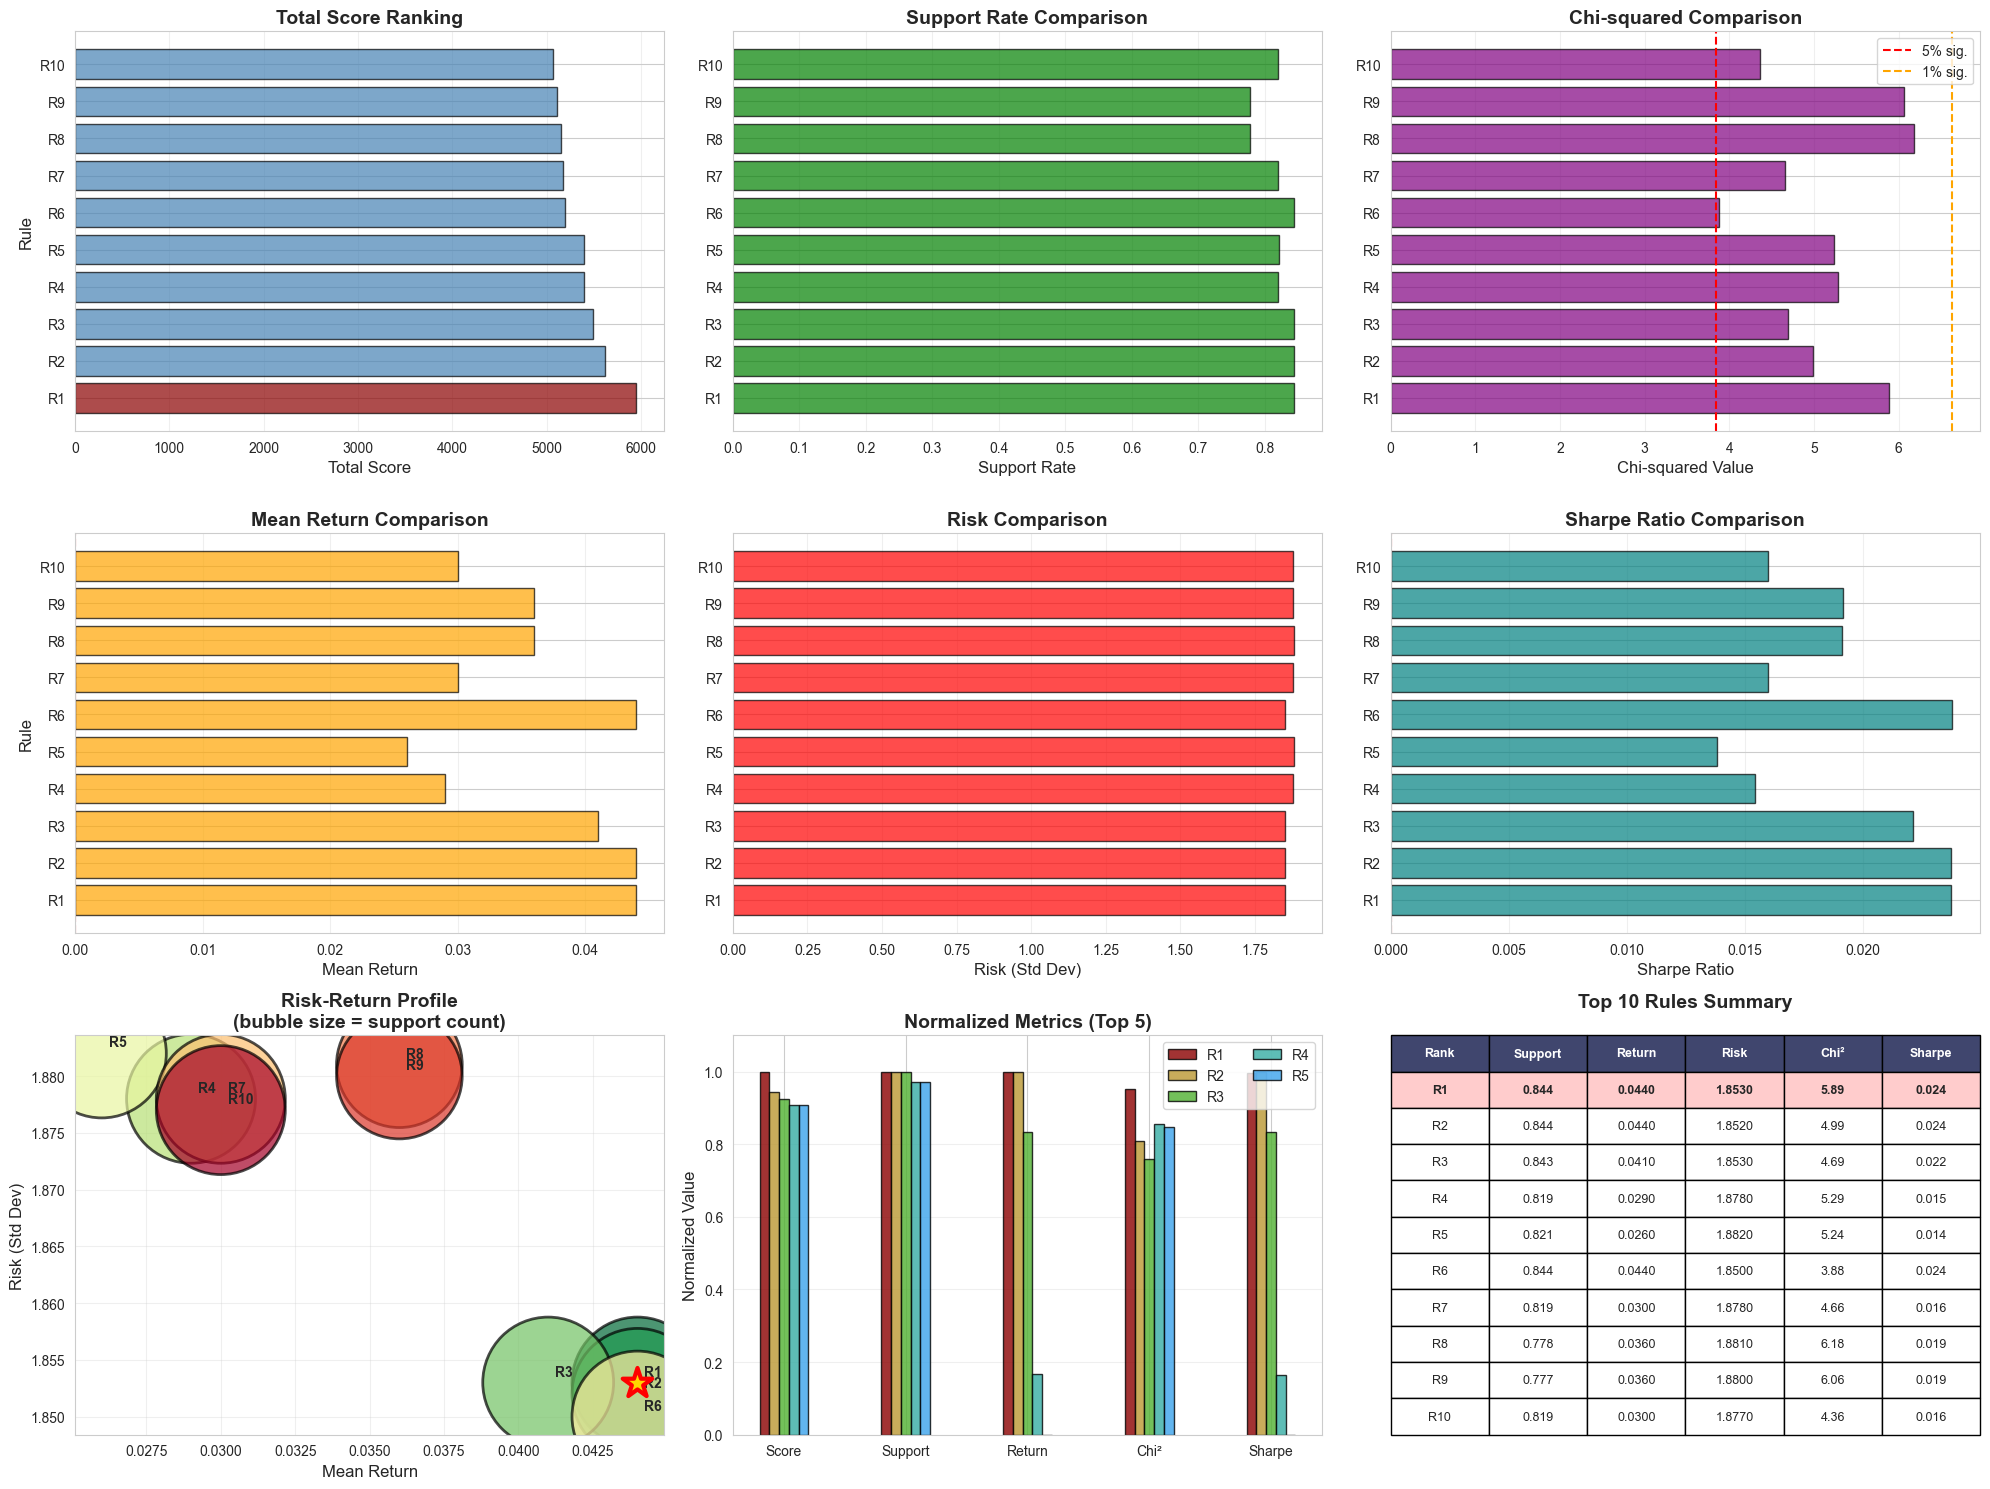


TOP 10 RULES DETAILED COMPARISON

Rank 1: 9434_Stay(t-1) & 6178_Stay(t-1)
  Score: 5949.90
  Support: 0.8435
  Return: 0.0440 ± 1.8530
  Chi²: 5.887
  Sharpe: 0.0237

Rank 2: 9434_Stay(t-2) & 6178_Stay(t-1)
  Score: 5617.68
  Support: 0.8437
  Return: 0.0440 ± 1.8520
  Chi²: 4.993
  Sharpe: 0.0238

Rank 3: 9434_Stay(t-3) & 6178_Stay(t-1)
  Score: 5493.23
  Support: 0.8429
  Return: 0.0410 ± 1.8530
  Chi²: 4.688
  Sharpe: 0.0221

Rank 4: 9434_Stay(t-0) & 7186_Stay(t-2)
  Score: 5401.88
  Support: 0.8193
  Return: 0.0290 ± 1.8780
  Chi²: 5.287
  Sharpe: 0.0154

Rank 5: 9434_Stay(t-2) & 7186_Stay(t-3)
  Score: 5401.01
  Support: 0.8205
  Return: 0.0260 ± 1.8820
  Chi²: 5.241
  Sharpe: 0.0138

Rank 6: 9434_Stay(t-0) & 6178_Stay(t-1)
  Score: 5198.63
  Support: 0.8435
  Return: 0.0440 ± 1.8500
  Chi²: 3.881
  Sharpe: 0.0238

Rank 7: 9434_Stay(t-3) & 7186_Stay(t-2)
  Score: 5176.37
  Support: 0.8190
  Return: 0.0300 ± 1.8780
  Chi²: 4.661
  Sharpe: 0.0160

Rank 8: 9434_Stay(t-1) & 1333_Stay

In [23]:
# 6-1: トップ10ルールの詳細比較
top_10_rules = filtered_df_unique.head(10)

fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# スコア分解
rule_labels = [f"R{i+1}" for i in range(len(top_10_rules))]

# 総合スコア
axes[0, 0].barh(rule_labels, top_10_rules['score'].values, 
                color=['darkred' if i == 0 else 'steelblue' for i in range(len(top_10_rules))],
                edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Total Score', fontsize=12)
axes[0, 0].set_ylabel('Rule', fontsize=12)
axes[0, 0].set_title('Total Score Ranking', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# サポート率
axes[0, 1].barh(rule_labels, top_10_rules['support_rate'].values, 
                color='green', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Support Rate', fontsize=12)
axes[0, 1].set_title('Support Rate Comparison', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Chi-squared
axes[0, 2].barh(rule_labels, top_10_rules['Chi_squared'].values, 
                color='purple', edgecolor='black', alpha=0.7)
axes[0, 2].axvline(3.84, color='red', linestyle='--', label='5% sig.')
axes[0, 2].axvline(6.63, color='orange', linestyle='--', label='1% sig.')
axes[0, 2].set_xlabel('Chi-squared Value', fontsize=12)
axes[0, 2].set_title('Chi-squared Comparison', fontsize=14, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='x')

# リターン
axes[1, 0].barh(rule_labels, top_10_rules['Actual_X_mean'].values, 
                color='orange', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Mean Return', fontsize=12)
axes[1, 0].set_ylabel('Rule', fontsize=12)
axes[1, 0].set_title('Mean Return Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# リスク（標準偏差）
axes[1, 1].barh(rule_labels, top_10_rules['Actual_X_sigma'].values, 
                color='red', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Risk (Std Dev)', fontsize=12)
axes[1, 1].set_title('Risk Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

# シャープレシオ（計算）
top_10_sharpe = top_10_rules['Actual_X_mean'] / (top_10_rules['Actual_X_sigma'] + 1e-6)
axes[1, 2].barh(rule_labels, top_10_sharpe.values, 
                color='teal', edgecolor='black', alpha=0.7)
axes[1, 2].axvline(0, color='red', linestyle='--')
axes[1, 2].set_xlabel('Sharpe Ratio', fontsize=12)
axes[1, 2].set_title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='x')

# リスク-リターン散布図
scatter = axes[2, 0].scatter(top_10_rules['Actual_X_mean'], 
                            top_10_rules['Actual_X_sigma'],
                            s=top_10_rules['support_count']*2,
                            c=range(len(top_10_rules)),
                            cmap='RdYlGn_r',
                            alpha=0.7,
                            edgecolors='black',
                            linewidth=2)

# トップルールを強調
axes[2, 0].scatter(top_10_rules.iloc[0]['Actual_X_mean'], 
                  top_10_rules.iloc[0]['Actual_X_sigma'],
                  s=500, marker='*', c='gold', 
                  edgecolors='red', linewidth=3, zorder=10)

for i, (idx, row) in enumerate(top_10_rules.iterrows()):
    axes[2, 0].annotate(f"R{i+1}", 
                       (row['Actual_X_mean'], row['Actual_X_sigma']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=10, fontweight='bold')

axes[2, 0].set_xlabel('Mean Return', fontsize=12)
axes[2, 0].set_ylabel('Risk (Std Dev)', fontsize=12)
axes[2, 0].set_title('Risk-Return Profile\n(bubble size = support count)', fontsize=14, fontweight='bold')
axes[2, 0].grid(True, alpha=0.3)

# レーダーチャート用のデータ準備
metrics_normalized = pd.DataFrame({
    'Score': top_10_rules['score'] / top_10_rules['score'].max(),
    'Support': top_10_rules['support_rate'] / top_10_rules['support_rate'].max(),
    'Return': (top_10_rules['Actual_X_mean'] - top_10_rules['Actual_X_mean'].min()) / 
              (top_10_rules['Actual_X_mean'].max() - top_10_rules['Actual_X_mean'].min() + 1e-6),
    'Chi²': top_10_rules['Chi_squared'] / top_10_rules['Chi_squared'].max(),
    'Sharpe': (top_10_sharpe - top_10_sharpe.min()) / (top_10_sharpe.max() - top_10_sharpe.min() + 1e-6)
})

x_metrics = np.arange(len(metrics_normalized.columns))
width = 0.08

for i in range(min(5, len(top_10_rules))):
    offset = (i - 2) * width
    color = 'darkred' if i == 0 else f"C{i}"
    axes[2, 1].bar(x_metrics + offset, metrics_normalized.iloc[i], 
                  width, label=f"R{i+1}", alpha=0.8, edgecolor='black', color=color)

axes[2, 1].set_xticks(x_metrics)
axes[2, 1].set_xticklabels(metrics_normalized.columns, rotation=0)
axes[2, 1].set_ylabel('Normalized Value', fontsize=12)
axes[2, 1].set_title('Normalized Metrics (Top 5)', fontsize=14, fontweight='bold')
axes[2, 1].legend(fontsize=10, ncol=2)
axes[2, 1].set_ylim(0, 1.1)
axes[2, 1].grid(True, alpha=0.3, axis='y')

# 詳細テーブル
axes[2, 2].axis('tight')
axes[2, 2].axis('off')

table_data = []
for i, (idx, row) in enumerate(top_10_rules.iterrows()):
    table_data.append([
        f"R{i+1}",
        f"{row['support_rate']:.3f}",
        f"{row['Actual_X_mean']:.4f}",
        f"{row['Actual_X_sigma']:.4f}",
        f"{row['Chi_squared']:.2f}",
        f"{top_10_sharpe.iloc[i]:.3f}"
    ])

table = axes[2, 2].table(
    cellText=table_data,
    colLabels=['Rank', 'Support', 'Return', 'Risk', 'Chi²', 'Sharpe'],
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

for i in range(6):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(6):
    table[(1, i)].set_facecolor('#ffcccc')
    table[(1, i)].set_text_props(weight='bold')

axes[2, 2].set_title('Top 10 Rules Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("TOP 10 RULES DETAILED COMPARISON")
print("="*80)
for i, (idx, row) in enumerate(top_10_rules.iterrows()):
    print(f"\nRank {i+1}: {row['Attr1']} & {row['Attr2']}")
    print(f"  Score: {row['score']:.2f}")
    print(f"  Support: {row['support_rate']:.4f}")
    print(f"  Return: {row['Actual_X_mean']:.4f} ± {row['Actual_X_sigma']:.4f}")
    print(f"  Chi²: {row['Chi_squared']:.3f}")
    print(f"  Sharpe: {top_10_sharpe.iloc[i]:.4f}")

## 最終サマリー

In [24]:
print("\n" + "="*80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)
print(f"\nTop Rule: {top_rule['Attr1']} & {top_rule['Attr2']}")
print(f"\n1. QUALITY METRICS")
print(f"   Overall Score: {top_rule['score']:.2f} (Rank #1 / {len(filtered_df_unique):,})")
print(f"   Support Rate: {top_rule['support_rate']:.4f} ({top_rule['support_rate']*100:.2f}%)")
print(f"   Chi-squared: {top_rule['Chi_squared']:.3f} (p < 0.05)")
print(f"\n2. PERFORMANCE METRICS")
print(f"   Mean Return: {top_rule['Actual_X_mean']:.4f}")
print(f"   Risk (Std Dev): {top_rule['Actual_X_sigma']:.4f}")
print(f"   Sharpe Ratio: {top_rule['Actual_X_mean']/(top_rule['Actual_X_sigma']+1e-6):.4f}")
print(f"   Excess Return: {top_rule['Actual_X_mean'] - top_rule['X_mean']:.4f}")
print(f"\n3. CONSISTENCY (across {len(top_rule_variations)} instances)")
print(f"   Win Rate: {win_rate:.2f}%")
print(f"   Outperformance Rate: {outperform_rate:.2f}%")
print(f"   Support Rate CV: {top_rule_variations['support_rate'].std()/top_rule_variations['support_rate'].mean():.4f}")
print(f"   High Significance Rate: {(top_rule_variations['Chi_squared'] > 3.84).sum() / len(top_rule_variations) * 100:.1f}%")
print(f"\n4. TIME SERIES ANALYSIS")
print(f"   Trend (slope): {reg.coef_[0]:.6f}")
print(f"   Final Cumulative Return: {cumulative_return.iloc[-1]:.4f}")
print(f"   Benchmark Cumulative Return: {cumulative_benchmark.iloc[-1]:.4f}")
print(f"   Outperformance: {(cumulative_return.iloc[-1] - cumulative_benchmark.iloc[-1]):.4f}")
print(f"\n5. DISTRIBUTIONAL PROPERTIES")
print(f"   Skewness: {skewness:.4f}")
print(f"   Kurtosis: {kurtosis:.4f}")
print(f"   VaR (95%): {var_95:.4f}")
print(f"   CVaR (95%): {cvar_95:.4f}")
print(f"\n6. STATISTICAL TESTS")
print(f"   Shapiro-Wilk (normality): p={shapiro_p:.4f}")
if 'DomMonth' in top_rule_variations.columns:
    print(f"   ANOVA (monthly effect): p={p_value:.4f}")
print("\n" + "="*80)
print("Analysis complete. All visualizations displayed above.")
print("="*80)


COMPREHENSIVE ANALYSIS SUMMARY

Top Rule: 9434_Stay(t-1) & 6178_Stay(t-1)

1. QUALITY METRICS
   Overall Score: 5949.90 (Rank #1 / 120,867)
   Support Rate: 0.8435 (84.35%)
   Chi-squared: 5.887 (p < 0.05)

2. PERFORMANCE METRICS
   Mean Return: 0.0440
   Risk (Std Dev): 1.8530
   Sharpe Ratio: 0.0237
   Excess Return: 0.0200

3. CONSISTENCY (across 19 instances)
   Win Rate: 89.47%
   Outperformance Rate: 89.47%
   Support Rate CV: 0.6232
   High Significance Rate: 100.0%

4. TIME SERIES ANALYSIS
   Trend (slope): 0.013179
   Final Cumulative Return: 0.6233
   Benchmark Cumulative Return: 0.9455
   Outperformance: -0.3222

5. DISTRIBUTIONAL PROPERTIES
   Skewness: -1.4435
   Kurtosis: 5.8027
   VaR (95%): -0.1064
   CVaR (95%): -0.8570

6. STATISTICAL TESTS
   Shapiro-Wilk (normality): p=0.0000
   ANOVA (monthly effect): p=0.6873

Analysis complete. All visualizations displayed above.
